In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import string
from nltk.stem.porter import PorterStemmer
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import math

from scipy.sparse import hstack

# Data Pre-processing

In [178]:
def pre_process_df(df):
    df["gender"] = df["gender"].astype('category')
    df["topic"] = df["topic"].astype('category')
    df["sign"] = df["sign"].astype('category')

    df["gender_cat"] = df["gender"].cat.codes
    df["topic_cat"] = df["topic"].cat.codes
    df["sign_cat"] = df["sign"].cat.codes

def get_word_count(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
    

In [179]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [180]:
pre_process_df(train)
pre_process_df(test)
get_word_count(train)
get_word_count(test)

## Data Processing on the Text Column

## Grouping the data by USER ID
### (found no change in gender,age, or topic across user.id at time of collecting data)

In [210]:
def remove_spaces_from_text_col(df):
    
    # remove duplicate spaces
    df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ',str(x)))
    # strip spaces around the sentence string
    df['text'] = df['text'].apply(lambda x: str(x).strip())


def group_by_user_id_col(df):
    # group by user id and get all the categorical variables
    cat = df.groupby(['user.id'])['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ].first()
    cat.columns = ['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ]
    
    # group by user id and get all text written by the user
    text = df.groupby(['user.id'])['text'].apply(lambda x:' '.join(x))
    
    # check for age column and get the age of each user
    if 'age' in df.columns:
        age = df.groupby(['user.id'])['age'].agg(np.average)
        
    return cat, text

def feature_creation(df):
    # get the total word count for each user
    tot_word_count = df.groupby(['user.id'])['word_count'].agg(np.sum)
    tot_word_count.name = 'tot_word_count'
    
    # get average word count for each user
    avg_word_count = df.groupby(['user.id'])['word_count'].agg(np.average)
    avg_word_count.name = 'avg_word_count'
    
    # get the number of posts by each user
    num_of_text = df.groupby(['user.id'])['user.id'].agg(['count'])
    num_of_text.columns = ['num_of_text']
    
    return tot_word_count, avg_word_count, num_of_text

def create_final_df(feature_dfs): # pass list of feature data frames created; returns concatenated data frame
    
    final_df = pd.concat(feature_dfs, axis=1)
    final_df = final_df.reset_index()
    
    return final_df
        

In [192]:
remove_spaces_from_text_col(train)
cat, text, age = group_by_user_id_col(train)
tot_word_count, avg_word_count, num_of_text = feature_creation(train)
final_df = create_final_df([cat, text, age, tot_word_count, avg_word_count, num_of_text])

In [193]:
final_df.head()

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,age,tot_word_count,avg_word_count,num_of_text
0,1,indUnk,male,Sagittarius,39,1,8,Doritos Fuel of Space urlLink : Ian Myers NASA...,17,2384,76.903226,31
1,3,indUnk,female,Leo,39,0,5,"Yeah, I set up this blog so Heather would be h...",16,1643,205.375000,8
2,4,Student,male,Aquarius,34,1,0,Not too much exciting has happened this weeken...,17,535,535.000000,1
3,5,Accounting,female,Pisces,0,0,7,European Pilgrimage For High school Students o...,47,9931,451.409091,22
4,6,Student,male,Pisces,34,1,7,Last night's dream is very blurry. The only de...,16,125684,189.854985,662


# Exploring the data

### Gender Division

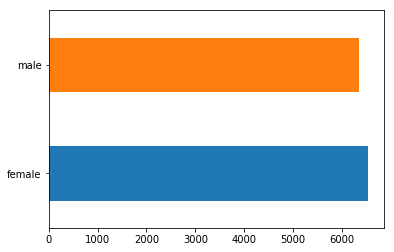

In [195]:
# train.groupby(['user.id'])['gender'].value_counts().plot(kind='barh')
final_df['gender'].value_counts().plot(kind='barh')
plt.show()

### Top 10 Topics by Frequency

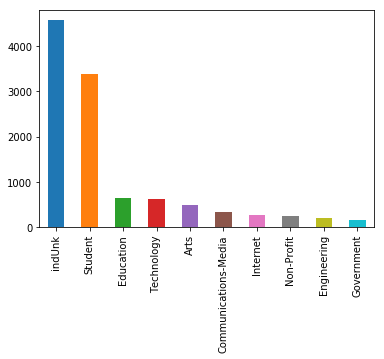

In [196]:
final_df['topic'].value_counts()[:10].plot(kind='bar')
plt.show()

### Distribution of Signs

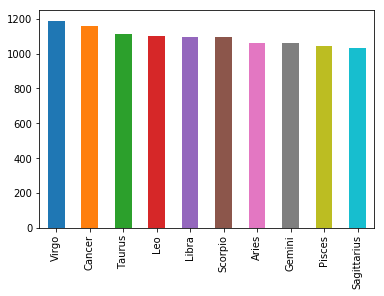

In [197]:
final_df['sign'].value_counts()[:10].plot(kind='bar')
plt.show()

# Working with the text column grouped data frame
## Removing stop words and punctuation

In [198]:
def text_processing(df):
    # get stop words from NLTK
    stop = stopwords.words('english')
    
    # remove stop words from the text
    df['text_processed'] = df['text'].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

    # removing punctuation 
    df['text_processed'] = df['text_processed'].str.replace('[^\w\s]','')
    
    # ignore case
    df['text_processed'] = df['text_processed'].str.lower()
    
    # count number of numerical values in the text
    df['numerics'] = df['text_processed'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # remove numbers from the text
    df['text_processed'] = df['text_processed'].str.replace('\d+', '')
    
    # get word roots
    df['text_processed'] = df['text_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return df


In [199]:
final_df = text_processing(final_df)

In [200]:
final_df.head()

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,age,tot_word_count,avg_word_count,num_of_text,text_processed,numerics
0,1,indUnk,male,Sagittarius,39,1,8,Doritos Fuel of Space urlLink : Ian Myers NASA...,17,2384,76.903226,31,doritos fuel space urllink ian myers nasa new ...,14
1,3,indUnk,female,Leo,39,0,5,"Yeah, I set up this blog so Heather would be h...",16,1643,205.375000,8,yeah i set blog heather would happyshe better ...,14
2,4,Student,male,Aquarius,34,1,0,Not too much exciting has happened this weeken...,17,535,535.000000,1,not much exciting happened weekend ive really ...,5
3,5,Accounting,female,Pisces,0,0,7,European Pilgrimage For High school Students o...,47,9931,451.409091,22,european pilgrimage for high school student st...,67
4,6,Student,male,Pisces,34,1,7,Last night's dream is very blurry. The only de...,16,125684,189.854985,662,last night dream blurry the detail i remember ...,963


In [13]:
final_df.to_csv('./final_df.csv')

# Extracting TF-IDF from the text data

In [201]:
# extract tf_idf for 1000 words with highest tf-idf values across all documents
vectorizer = TfidfVectorizer(min_df=5, max_features=1000)
X_tfidf = vectorizer.fit_transform(final_df['text_processed']) 

In [203]:
# extract the features created on the final training dataframe
X_feature = final_df[['topic_cat', 'avg_word_count','num_of_text', 'numerics']]
# stack the tf-idf and other features together
X = hstack([X_tfidf,X_feature.values])
# get the outcome variable from the data frame
y = final_df.age

X

## Making the model

In [66]:
# split the data into 80 percent train and 20 percent test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4200)

In [127]:
# make a linear regression model
linreg = LinearRegression(normalize=True)

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [113]:
X

<12880x10004 sparse matrix of type '<class 'numpy.float64'>'
	with 11279197 stored elements in COOrdinate format>

## Making predictions

In [207]:
# # remove duplicate spaces
# test['text'] = test['text'].apply(lambda x: re.sub(' +', ' ',str(x)))
# # strip spaces around the sentence string
# test['text'] = test['text'].apply(lambda x: str(x).strip())
# # get the word count for each blog
# test['word_count'] = test['text'].apply(lambda x: len(str(x).split(" ")))

In [212]:
remove_spaces_from_text_col(test)
cat, text = group_by_user_id_col(test)
tot_word_count, avg_word_count, num_of_text = feature_creation(test)
test_df = create_final_df([cat, text, tot_word_count, avg_word_count, num_of_text])

In [214]:
test_df = text_processing(test_df)

In [216]:
test_df.head()

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,tot_word_count,avg_word_count,num_of_text,text_processed,numerics
0,2,Military,male,Taurus,26,1,10,I finally saw Nathan's tattoo tonight. I like ...,833,119.000000,7,i finally saw nathans tattoo tonight i like it...,6
1,8,indUnk,male,Aquarius,39,1,0,Today was the last day and the shortest. We ha...,11790,170.869565,69,today last day shortest we one session lasted ...,147
2,9,Arts,female,Taurus,4,0,10,What the hell am I doing on the internet? Its ...,136937,379.326870,361,what hell i internet it am song exactly where ...,508
3,10,indUnk,male,Pisces,39,1,7,the hotel&nbsp; urlLink urlLink the thrid & wi...,4688,213.090909,22,hotelnbsp urllink urllink thrid winning goalnb...,37
4,11,RealEstate,female,Virgo,30,0,11,Last night I received message from a friend in...,1098,274.500000,4,last night i received message friend minnesota...,2


In [217]:
# get the tf-idf of the same vocabulary of words learnt while fitting
X_test = vectorizer.transform(test_df['text_processed'])
# get the same feature from the test data as from the train data set
X_test_cat = test_df[['topic_cat', 'avg_word_count','num_of_text', 'numerics']]
# stack the tf-idf and extracted features together
X_test_mat = hstack([X_test,X_test_cat.values])

In [218]:
X_test_mat

<6440x1004 sparse matrix of type '<class 'numpy.float64'>'
	with 2469709 stored elements in COOrdinate format>

In [219]:
# predict on the test data
y_pred_test = linreg.predict(X_test_mat)

In [220]:
# write predictions to file
y_pred_test = pd.Series(y_pred_test)
predictions = pd.concat([test_df['user.id'], y_pred_test], axis=1)
predictions.columns = ['user.id','age']
predictions.age = np.floor(predictions.age)
predictions.to_csv('./predictions_text_test.csv', index=False)